# Read Length Distribution

## Setup


In [3]:

import itertools
import numpy as np

from RiboMetric.metrics import (
    read_length_distribution_IQR_normalised_metric,
    read_length_distribution_coefficient_of_variation_metric,
    read_length_distribution_bimodality,
    read_length_distribution_normality_metric,
    read_length_distribution_max_prop_metric,
)

## Simulated Inputs


In [4]:
import numpy as np

def simulate_read_lengths(n_samples, params, min_length=18, max_length=35):
    """
    Simulate read length distributions using a mixture of normal distributions.

    Args:
        n_samples (int): Number of read lengths to simulate.
        params (list): List of tuples (mean, std, weight) for each component distribution.
        min_length (int): Minimum read length (inclusive).
        max_length (int): Maximum read length (inclusive).

    Returns:
        np.ndarray: Array of simulated read lengths.
    """
    probs = [compute_mixture_density(length, params) for length in range(min_length, max_length + 1)]
    probs_sum = sum(probs)
    probs = [p / probs_sum for p in probs]  # Normalize probabilities

    read_lengths = np.random.choice(
        np.arange(min_length, max_length + 1),
        size=n_samples,
        p=probs
    )
    return read_lengths

def compute_mixture_density(x, params):
    """
    Compute the density of a mixture of normal distributions at a given point x.

    Args:
        x (float): Point at which to compute the density.
        params (list): List of tuples (mean, std, weight) for each component distribution.

    Returns:
        float: Density of the mixture distribution at x.
    """
    density = 0
    for mean, std, weight in params:
        density += weight * np.exp(-(x - mean)**2 / (2 * std**2)) / (np.sqrt(2 * np.pi) * std)
    return density

# Example usage
n_samples = 10000
params = [
    (22, 2, 0.3),   # Unimodal component
    (26, 1, 0.4),   # Unimodal component
    (30, 3, 0.3)    # Bimodal component
]

read_lengths = simulate_read_lengths(n_samples, params)

In [5]:
import numpy as np

def simulate_normal_distributions(n_samples, n_distributions, min_length=18, max_length=35):
    """
    Simulate normally distributed read length distributions with varying standard deviations.

    Args:
        n_samples (int): Number of read lengths to simulate per distribution.
        n_distributions (int): Number of distributions to simulate.
        min_length (int): Minimum read length (inclusive).
        max_length (int): Maximum read length (inclusive).

    Returns:
        list: List of arrays, each containing simulated read lengths for one distribution.
    """
    distributions = []
    for _ in range(n_distributions):
        mean = np.random.randint(min_length, max_length)
        std_dev = np.random.uniform(1, 5)
        read_lengths = np.random.normal(loc=mean, scale=std_dev, size=n_samples)
        read_lengths = np.clip(read_lengths, min_length, max_length).astype(int)
        distributions.append(read_lengths)
    return distributions

# Example usage
n_samples = 1000
n_normal_distributions = 100
normal_distributions = simulate_normal_distributions(n_samples, n_normal_distributions)


In [34]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# make multifigure sub plot of 9 random distributions
n_rows = 3
n_cols = 3
fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=[f"Distribution {i+1}" for i in range(n_rows * n_cols)])

for i, dist in enumerate(normal_distributions):
    row = i // n_cols + 1
    col = i % n_cols + 1
    
    if i >= n_rows * n_cols:
        break
    
    rld_dict = {
        length: count for length, count in zip(*np.unique(dist, return_counts=True))
    }
    
    IQR_score = read_length_distribution_IQR_normalised_metric(rld_dict)
    CoV_score = read_length_distribution_coefficient_of_variation_metric(rld_dict)
    Bimodal_score = read_length_distribution_bimodality(rld_dict)
    Normal_score = read_length_distribution_normality_metric(rld_dict)
    Max_prop_score = read_length_distribution_max_prop_metric(rld_dict)
    
    fig.add_trace(go.Histogram(x=dist, histnorm='probability', name=f'Distribution {i+1}'), row=row, col=col)
    
    fig.update_xaxes(title_text='Read Length', row=row, col=col)
    fig.update_yaxes(title_text='Density', row=row, col=col)
    
    title = f"IQR: {IQR_score:.2f}, CoV: {CoV_score:.2f}, Bimodality: {Bimodal_score:.2f}, Normality: {Normal_score:.2f}, Max Prop: {Max_prop_score:.2f}"
    fig.layout.annotations[i].update(text=title)

fig.update_layout(
    height=800,
    barmode='overlay',
)

fig.show()

In [10]:
import pandas as pd

In [17]:
predf = {
    'IQR': [],
    'CoV': [],
    'Bimodal': [],
    'Normal': [],
    'Max Prop': [],
}
for i, dist in enumerate(normal_distributions):
    rld_dict = {
        length: count for length, count in zip(*np.unique(dist, return_counts=True))
    }
    predf['IQR'].append(read_length_distribution_IQR_normalised_metric(rld_dict))
    predf['CoV'].append(read_length_distribution_coefficient_of_variation_metric(rld_dict))
    predf['Bimodal'].append(read_length_distribution_bimodality(rld_dict))
    predf['Normal'].append(read_length_distribution_normality_metric(rld_dict))
    predf['Max Prop'].append(read_length_distribution_max_prop_metric(rld_dict))


df = pd.DataFrame.from_dict(predf)
df.shape

(100, 5)

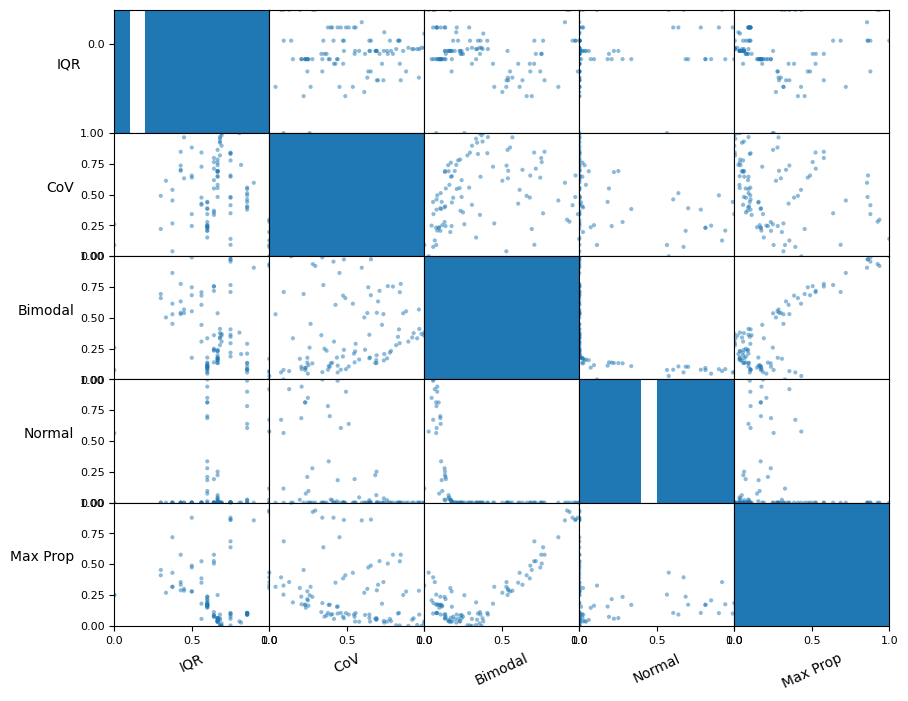

In [24]:

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

scaler = MinMaxScaler()

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 8))
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

pd.plotting.scatter_matrix(df_scaled, ax=axes)

for ax in axes.flatten():
    ax.tick_params(axis='x', labelrotation=0)
    # set vmin and vmax for all subplots
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    
    # rotate axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 25)
    ax.set_ylabel(ax.get_ylabel(), rotation = 0, ha = 'right')

Text(0.5, 1.0, 'Spearman Correlation')

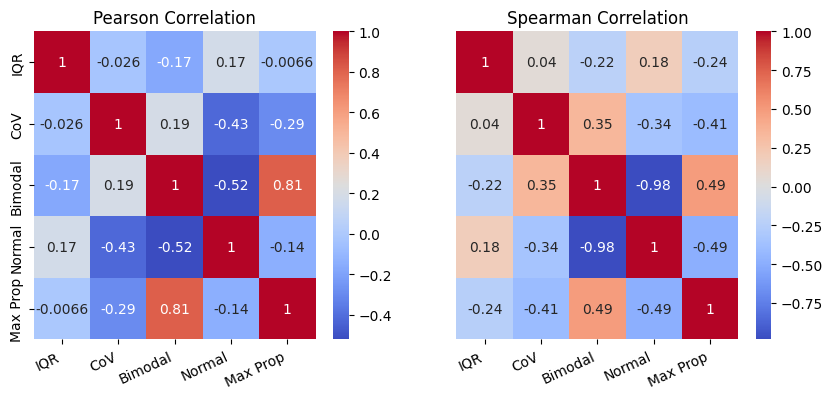

In [26]:
import seaborn as sns

corr_df = df_scaled

corr_pearson = corr_df.corr()
corr_spearman = corr_df.corr(method='spearman')

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Create a heatmap for the Pearson correlation
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', ax=ax[0])
ax[0].set_title('Pearson Correlation')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=25, horizontalalignment='right')

# Create a heatmap for the Spearman correlation
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', ax=ax[1])
# turn off labels on y axis 
ax[1].set_yticks([])
#rotate x tick
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=25, horizontalalignment='right')
ax[1].set_title('Spearman Correlation')